In [23]:
### FUNCTION DEFINITION BLOCK ###

# Read the modeling data from the CSV file
def get_Strategic_Subject_List_Data():
    raw_data = pd.read_csv("Strategic_Subject_List.csv", low_memory = False)
    #Replace spaces in column names by underscore
    raw_data.columns = [x.strip().replace(' ', '_') for x in raw_data.columns]
    #Replace the blank values with NAN 
    raw_data.replace(r'^\s+$', np.nan, regex=True, inplace = True)
    return(raw_data)

# Used only age as the predictor
def feature_selection(raw_data):
    #final_features = raw_data[['SSL_SCORE','AGE_TO']]
    final_features = raw_data[['SSL_SCORE','AGE_GROUP']]
    return(final_features)

# Segregating the Categorical and Numerical Variables
def defining_categorical(final_features):
    
    categorical = final_features.select_dtypes(include=['object'])
    numeric = final_features.select_dtypes(exclude=['object'])

    #Defining the Dummy variables for the categorical variables 
    for name, values in categorical.items():
        dummies = pd.get_dummies(values.str.strip(), prefix = name, dummy_na=True)
        numeric = pd.concat([numeric, dummies], axis=1)

    return(numeric)

#Imputing the missing values 
def impute_missing_values(numeric):
    for name in numeric:
        if pd.isnull(numeric[name]).sum() > 0:
            numeric["%s_mi" % (name)] = pd.isnull(numeric[name])
            median = numeric[name].median()
            numeric[name] = numeric[name].apply(lambda x: median if pd.isnull(x) else x)
    return(numeric)

In [13]:
# Importing the required libraries
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
from sklearn import preprocessing


#Adjusting the display options of Pandas
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


#Importing the python matplot library for exploratory data analysis
import matplotlib.pyplot as plt
import pandas as pd

# Import the raw data from the csv file
raw_data = get_Strategic_Subject_List_Data()

# Selecting final features for the model
final_features = feature_selection(raw_data)

In [14]:
### Data Processing Block ###

# Converting the required variables to categorical 
numeric = defining_categorical(final_features)
# Imputing missing values
numeric = impute_missing_values(numeric)


In [15]:
numeric['SSL_SCORE'] = numeric['SSL_SCORE'].apply(lambda x: 0 if x < 350 else 1)

In [16]:
# Defining the target variable and independent variables

y = numeric['SSL_SCORE']
X = numeric.drop(['SSL_SCORE'], axis = 1)

# Creating a Holdout for Testing of 20%
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y )

In [17]:
from sklearn.ensemble import ExtraTreesClassifier
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
feature_names = X.columns
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 6 (0.770072)
2. feature 1 (0.076082)
3. feature 0 (0.058946)
4. feature 2 (0.050604)
5. feature 3 (0.035347)
6. feature 4 (0.007699)
7. feature 5 (0.001075)
8. feature 7 (0.000176)


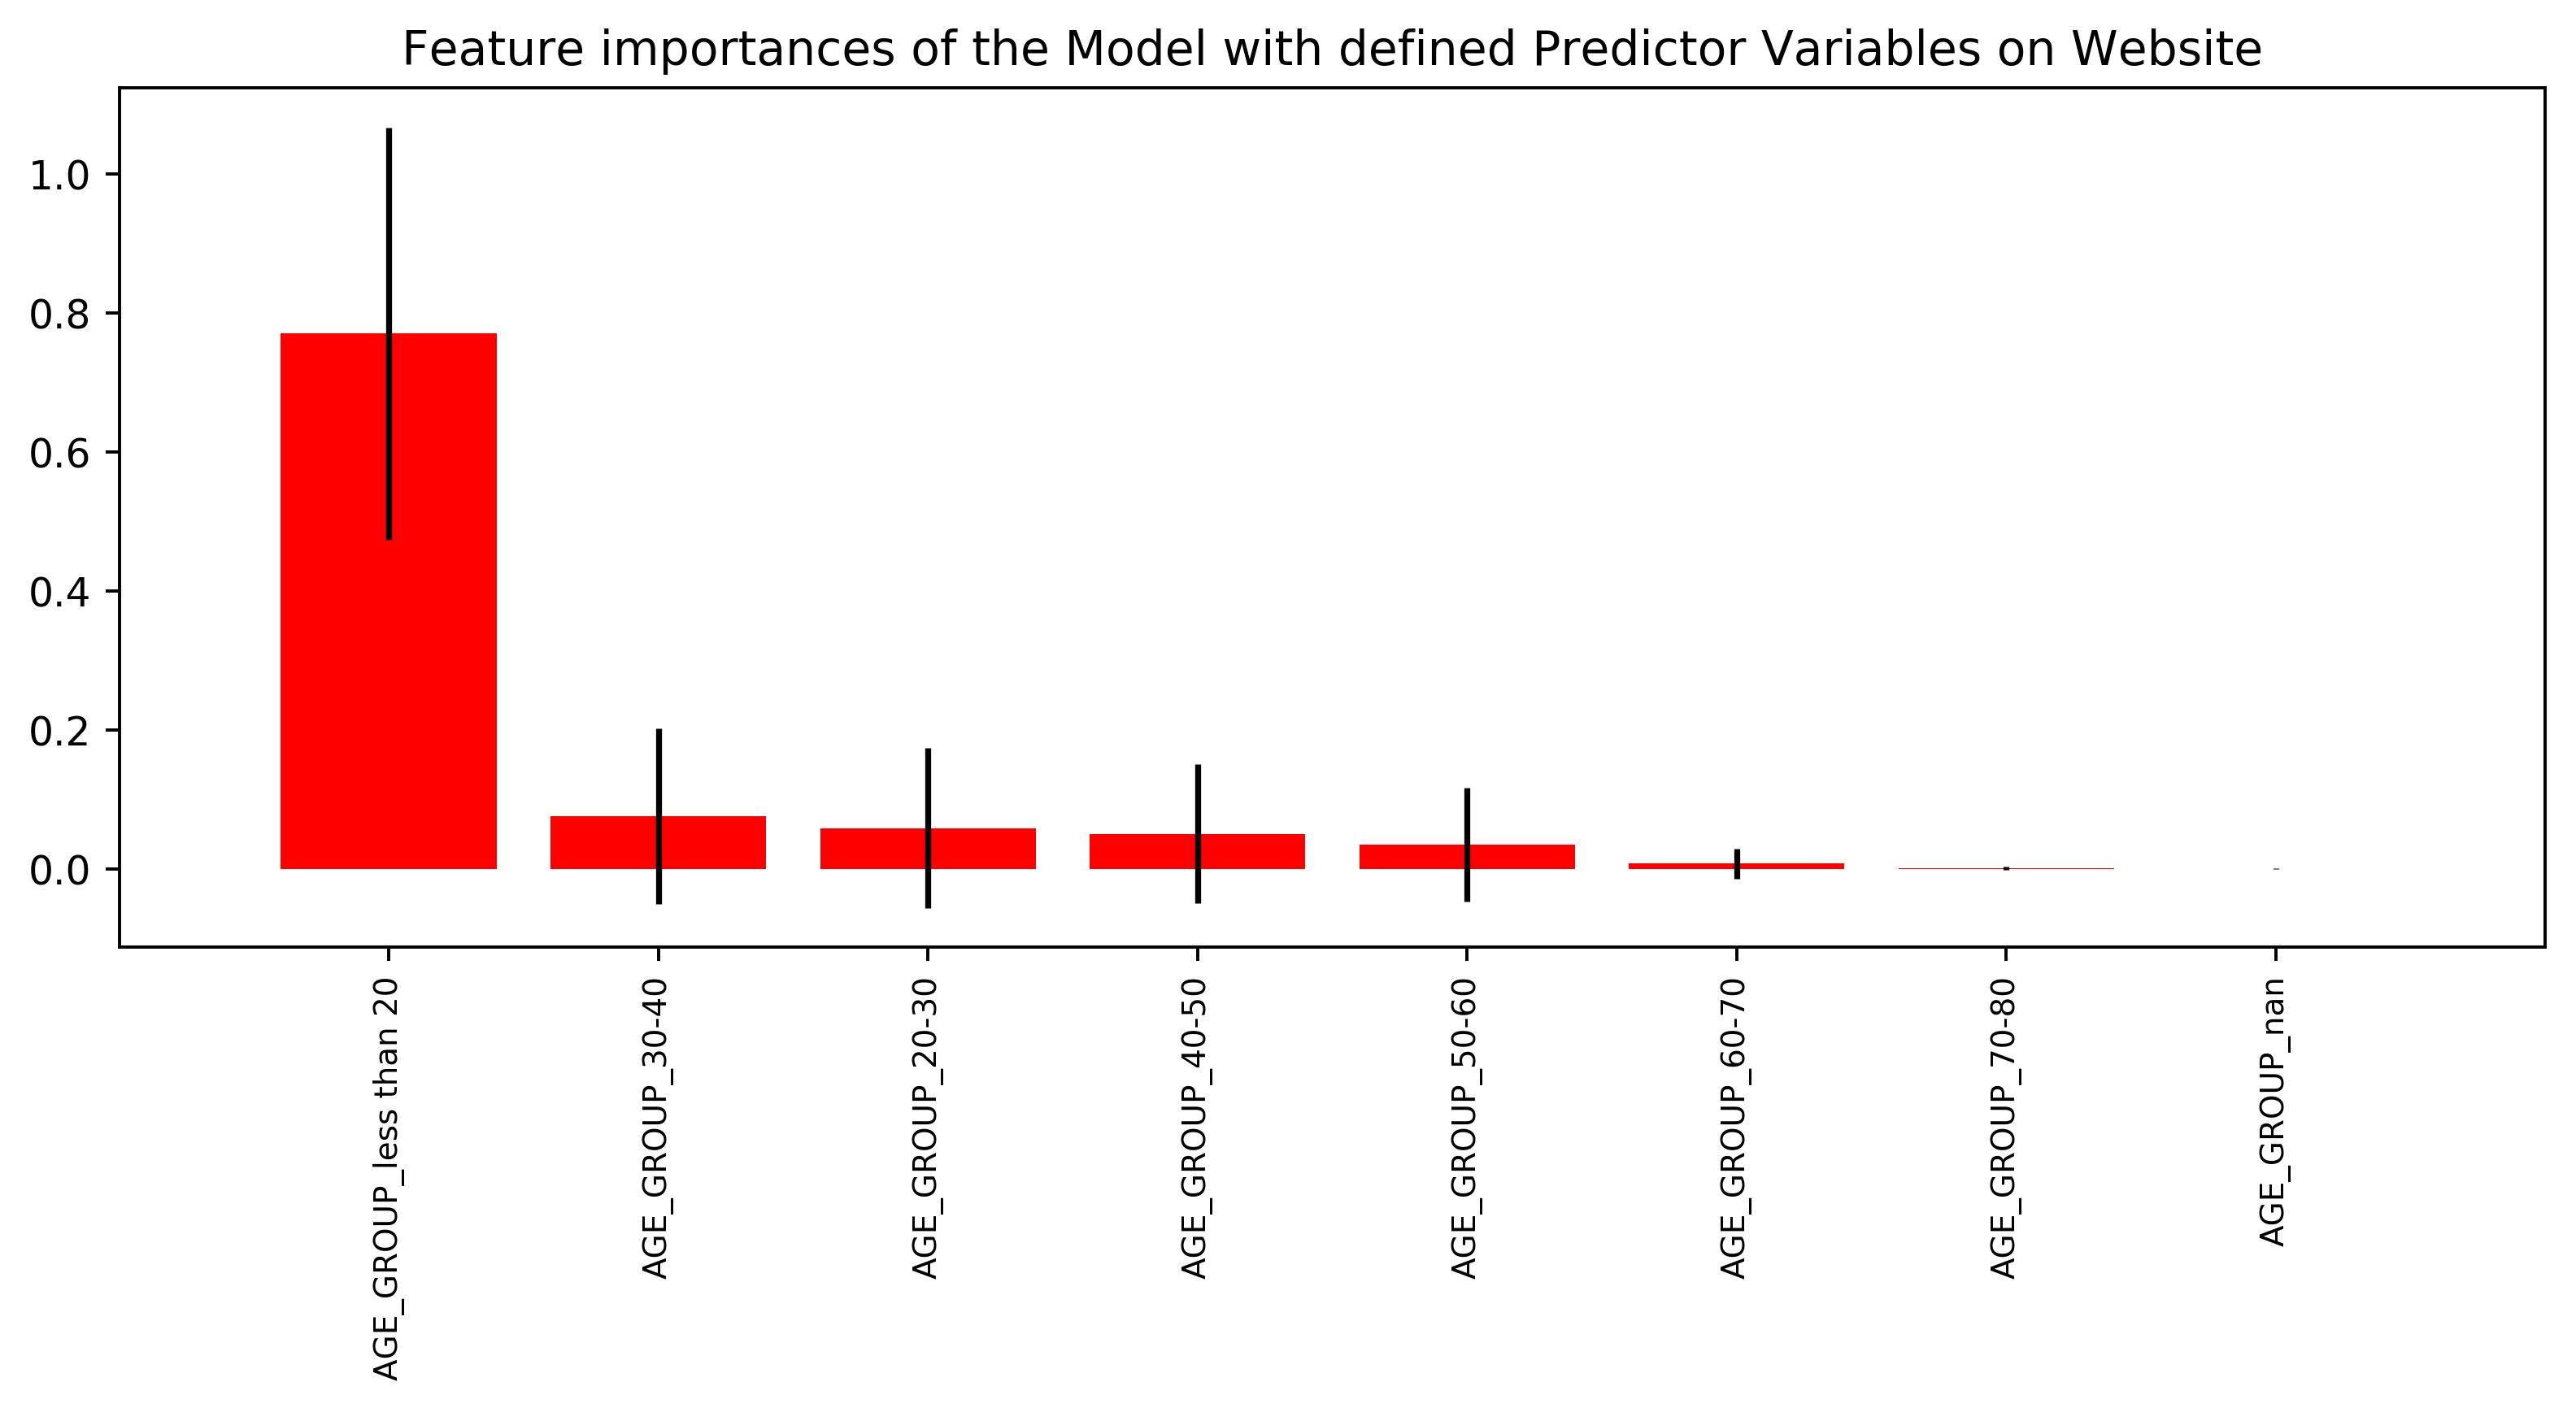

In [18]:
# Plot the feature importances of the forest
plt.figure(figsize=(11, 4), dpi=350)
plt.title("Feature importances of the Model with defined Predictor Variables on Website")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices],rotation=90,size=8)
plt.xlim([-1, X.shape[1]])
plt.show()

In [29]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
# set up cv
from sklearn import model_selection
cv = model_selection.KFold(5)

# pipeline
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', lr) ])

# tune the model
#my_ratio = np.linspace(0.1,1, num = 10)
#my_alpha = np.logspace(0.001, 1, num = 10)

from sklearn.model_selection import GridSearchCV
optimized_lr = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid=dict()
                            , scoring = 'roc_auc'
                            , verbose = 1
                            , n_jobs = -1
                           )
optimized_lr.fit(X_train, y_train)


#Get the best estimator from the grid Search
print(optimized_lr.best_estimator_)
print(" The optimized_lr.best_score is : ", optimized_lr.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.3s finished


Pipeline(steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
 The optimized_lr.best_score is :  0.881060243435


In [30]:
# the cofficients value
optimized_lr.best_estimator_.steps[-1][1].coef_

array([[ 1.09164775, -0.47974966, -1.34832517, -1.37639041, -0.67301426,
        -0.24159346,  1.7246457 , -0.09889363]])

In [31]:
# the intercept value
optimized_lr.best_estimator_.steps[-1][1].intercept_

array([-5.05420683])

In [28]:
import statsmodels.api as sm
results = sm.GLM(y, X).fit()
print(results.summary())

In [32]:
####################     Test on Hold Out for Random Forest as it has the Higest score    #########################

from sklearn.metrics import roc_auc_score
y_pred = optimized_lr.predict_proba(X_test)[:, 1]

roc_on_holdout = roc_auc_score(y_test, y_pred)

print("The AUC the final model choosen is ", roc_on_holdout)

The AUC the final model choosen is  0.878501311541


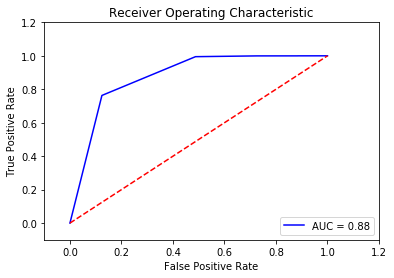

In [33]:
##################################               Plotting the ROC Curve               #############################
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()